In [133]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
from time import time

from astropy.table import Table, vstack

import numpy as np 

import scipy.ndimage
from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.mlab as ml
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MaxNLocator

from astroML.stats import binned_statistic_2d

from cap_loess_2d import loess_2d
from cap_plot_velfield import plot_velfield

%config InlineBackend.figure_format='retina'
plt.rcParams['figure.dpi'] = 100.0
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12.0
plt.rc('text', usetex=True)

from hsc_massive import \
    s16a_path, \
    sample_selection, \
    prepare_sed, \
    catalog_summary, \
    mass_function, \
    smhm, \
    plotting
    
from um_model_plot import \
    plot_logmh_sig_logms_tot, \
    plot_logmh_logms_tot


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [164]:
from um_ins_exs_model import InsituExsituModel

### Test basic model setup

In [165]:
um_test = InsituExsituModel()

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin1
# There are 17 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    12 bins at 10.60 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


#### Relation between halo mass and the total stellar mass within the halo

# Use 385125 galaxies for the fitting...
# SHMR : logms_halo = 0.7551 x logmh_vir + 1.4931


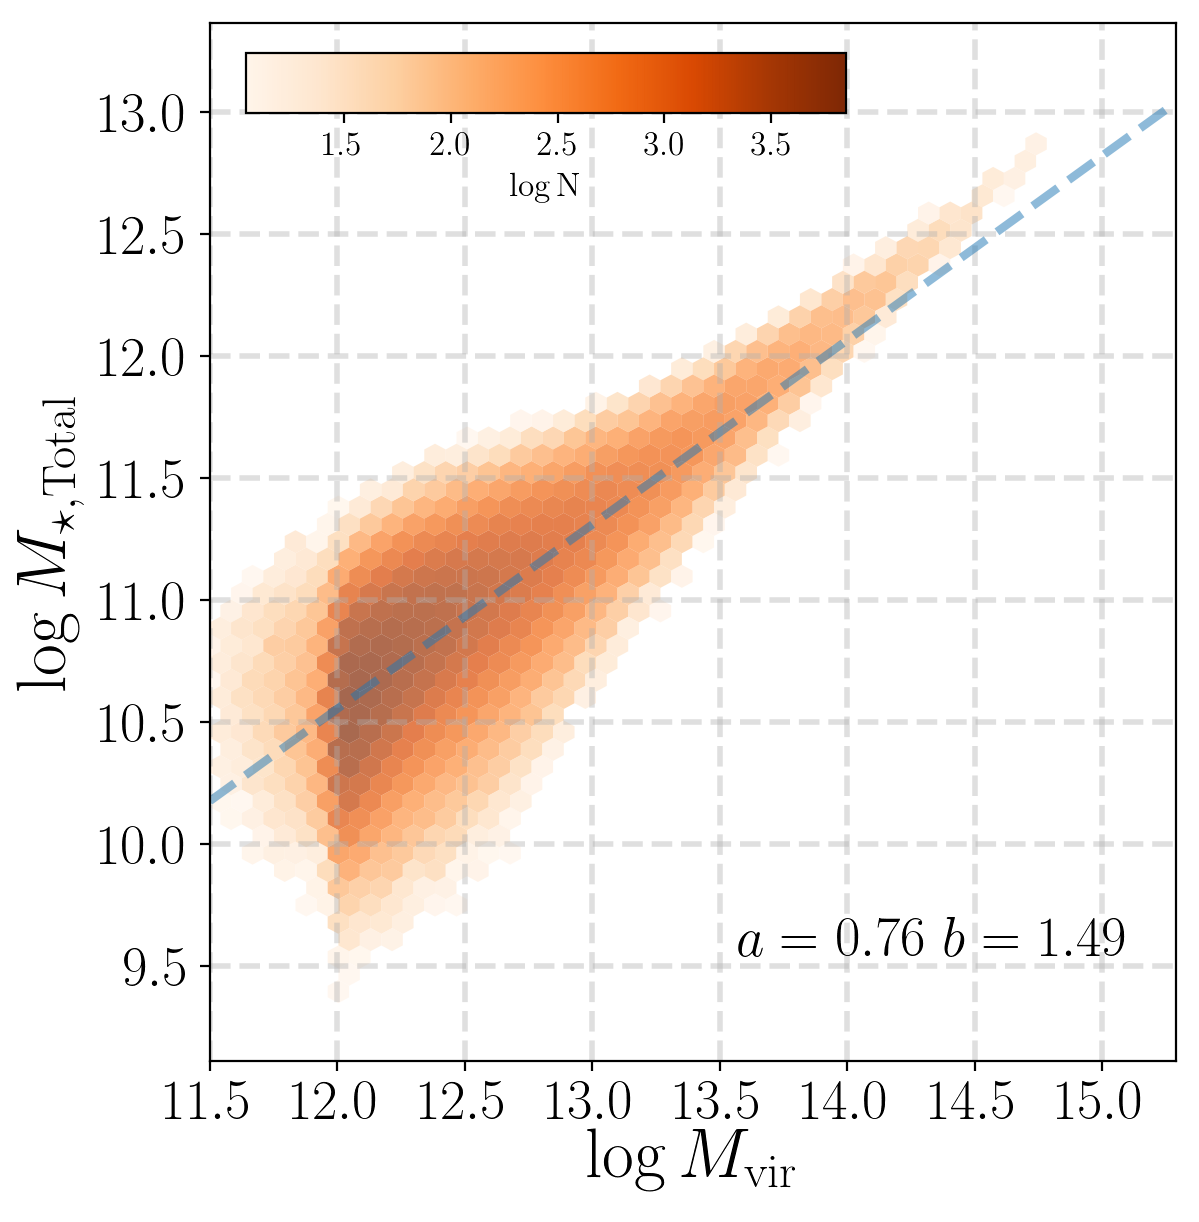

In [125]:
shmr_a, shmr_b = um_test.mockFitSimpleSHMR(um_min_mvir=11.5)

um_cen = um_test.um_mock[um_test.um_mock['mask_central']]
um_cen = um_cen[um_cen['logmh_vir'] > 11.5]

fig_logmh_logms_tot = plot_logmh_logms_tot(um_cen['logmh_vir'], 
                                           um_cen['logms_halo'],
                                           shmr_a, shmr_b)

#### Relation between halo mass and the scatter of total stellar mass within the halo

# Mh-SigMs : Sig(logms_halo) = -0.0824 x logmh_vir + 1.2737


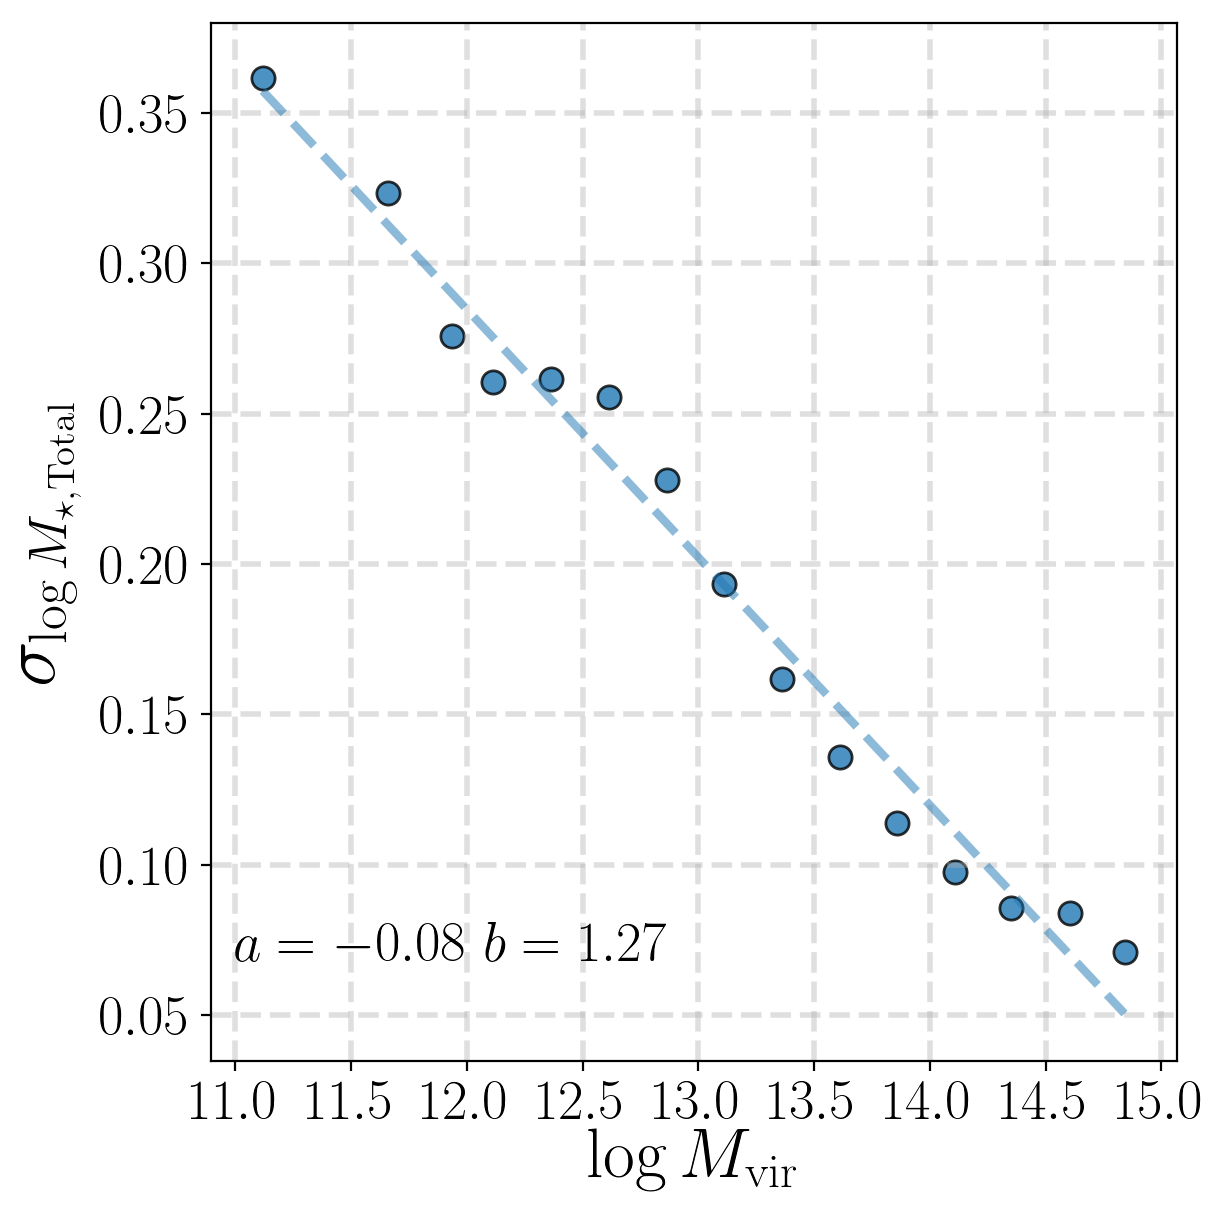

In [60]:
sigms_a, sigms_b, logmh_cen, sig_logms_tot = um_test.mockFitSimpleMhScatter(um_min_mvir=11.5, 
                                                                            n_bins=15)

fig_logmh_sig_logms_tot = plot_logmh_sig_logms_tot(logmh_cen, sig_logms_tot,
                                                   sigms_a, sigms_b)

#### Display the obseved stellar mass functions

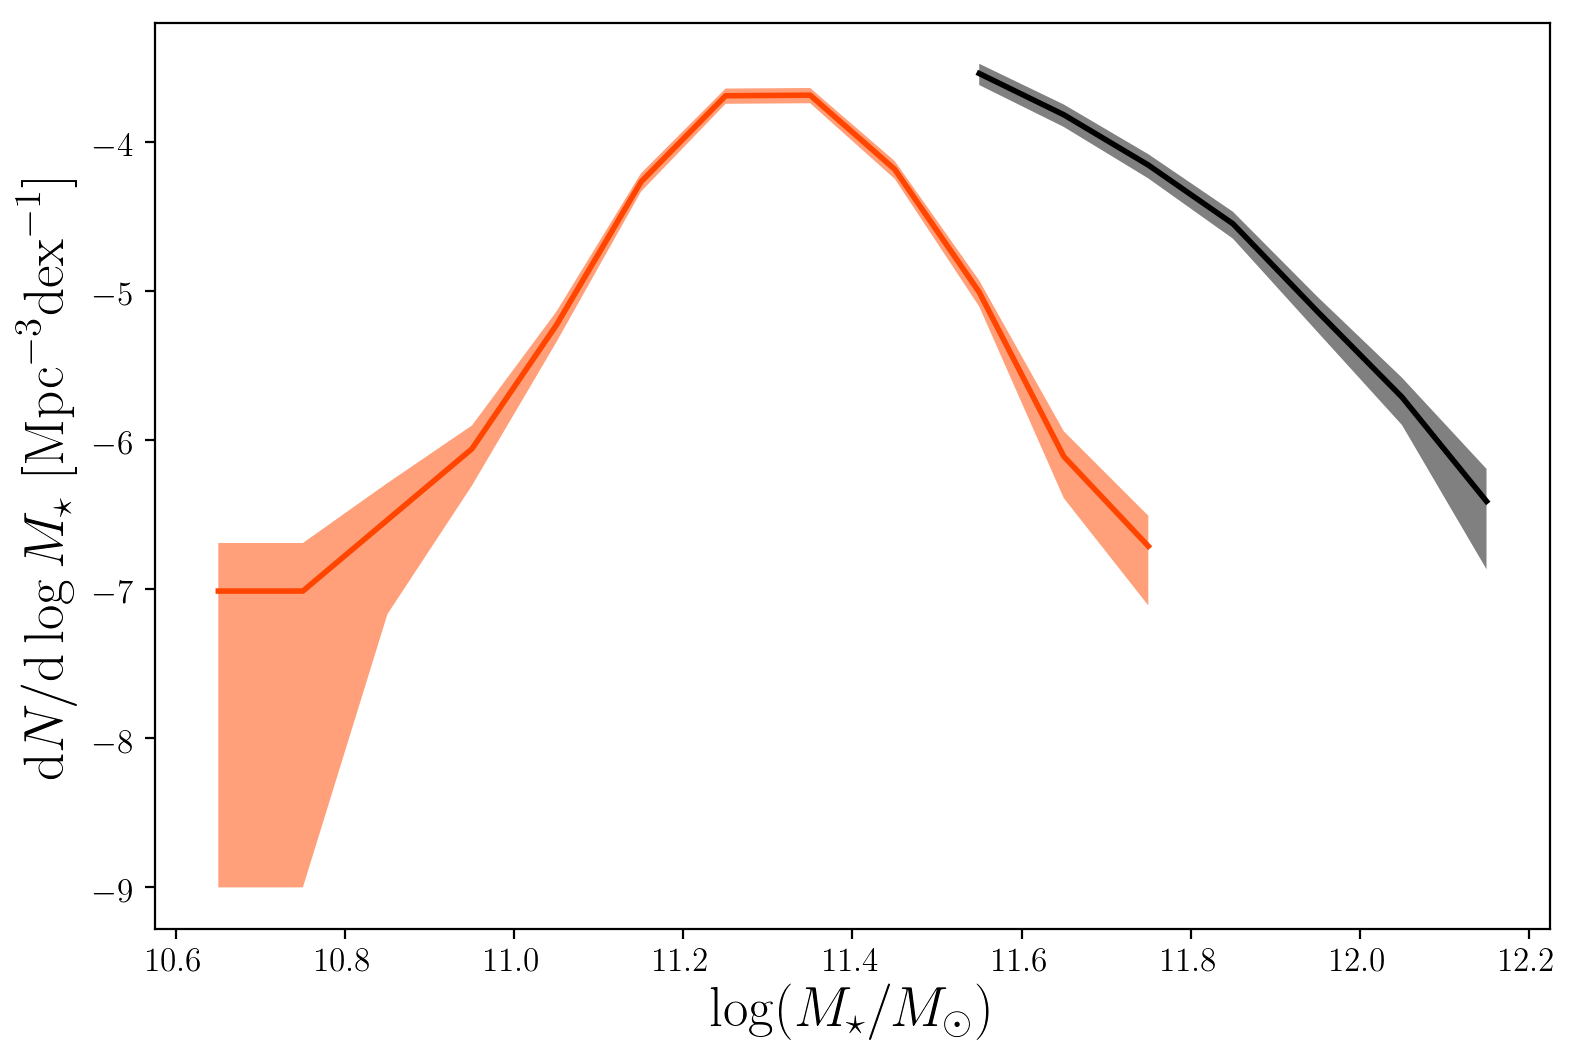

In [151]:
fig_obs_smf = um_test.showObsSMF()

### Test making simple model predicitons

In [166]:
um_test = InsituExsituModel(model_type='simple')

param_simple = (0.76, 1.49, -0.0824, 1.2737)

um_mass_predicted = um_test.umPredictMass(param_simple, 
                                          constant_bin=False)

logms_inn_mod, logms_tot_mod, logms_halo_mod, mask_tot, um_mock_use = um_mass_predicted

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin1
# There are 17 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    12 bins at 10.60 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


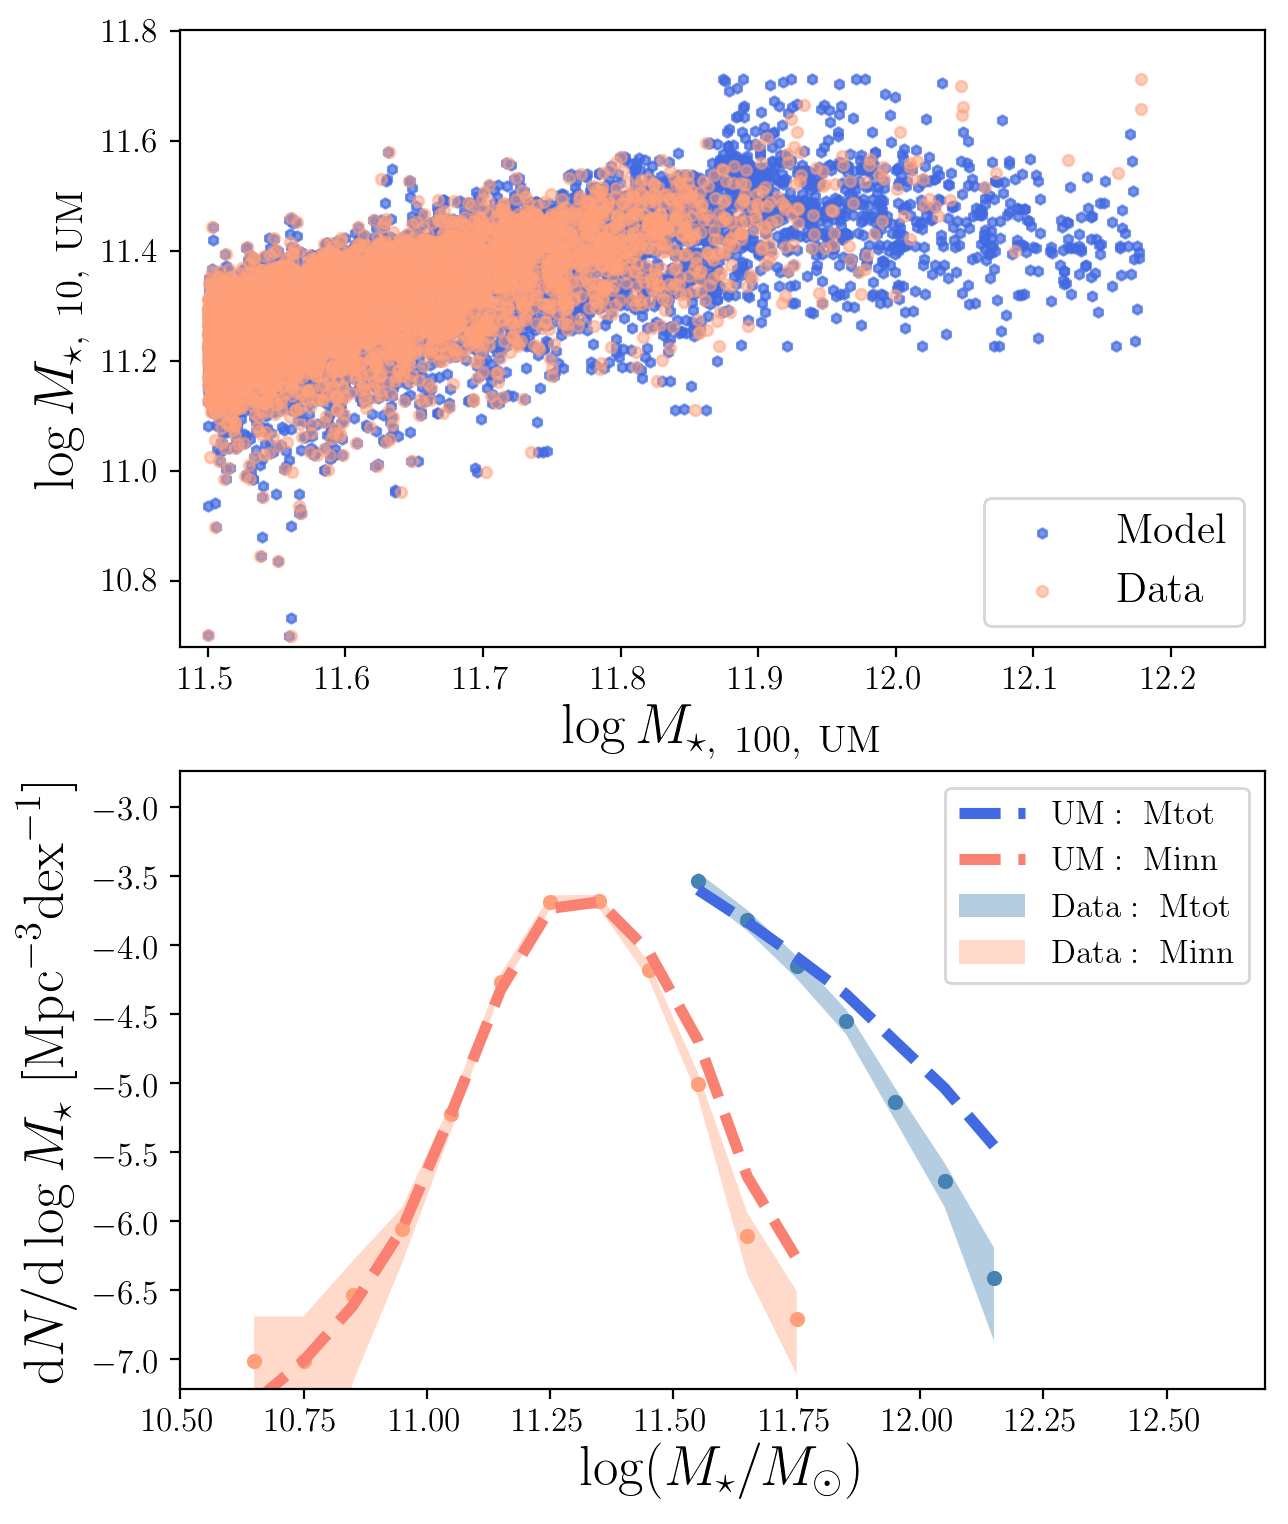

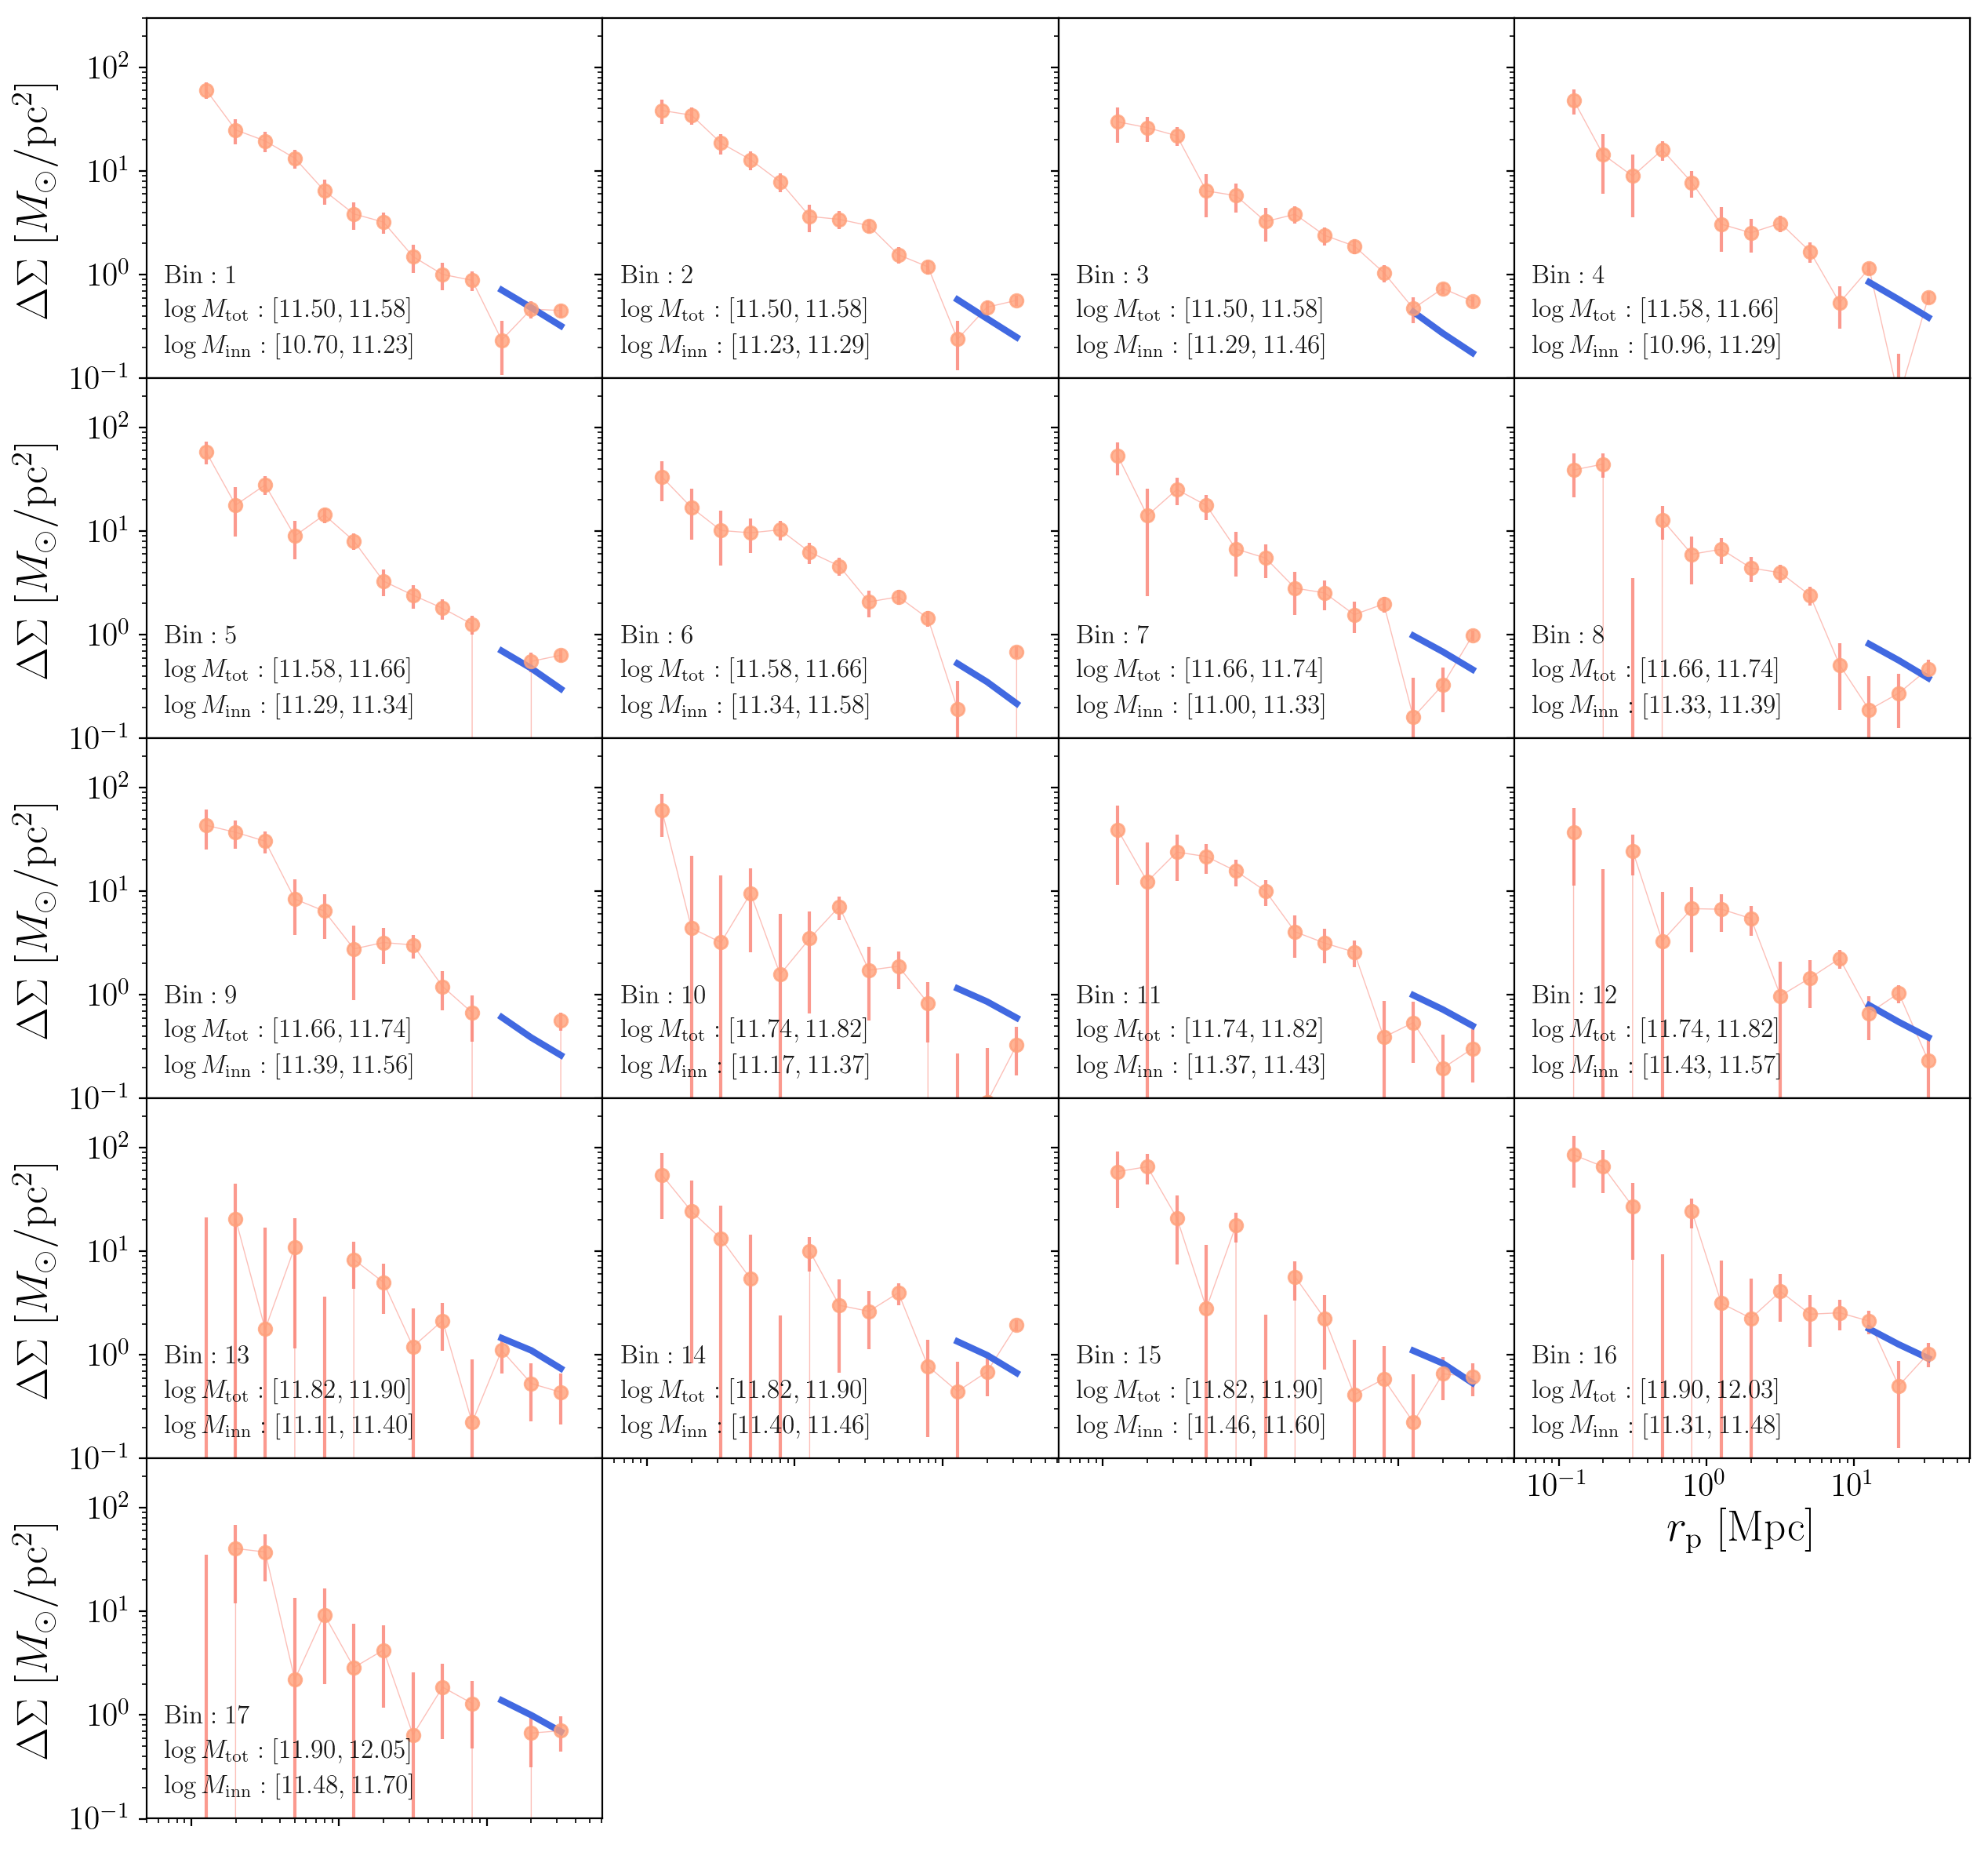

In [161]:
um_mod_predicted = um_test.umPredictModel(param_simple, 
                                          plotSMF=True, 
                                          plotWL=True,
                                          return_wl_mhalo=False,
                                          constant_bin=False)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_inn_mod, logms_tot_mod, logms_halo_mod, 
 mask_tot, um_mock_use) = um_mod_predicted

In [145]:
xx = logms_tot_mod
yy = logms_inn_mod
zz = um_mock_use['logmh_vir']

xMin, xMax = np.nanmin(xx), np.nanmax(xx)
yMin, yMax = np.nanmin(yy), np.nanmax(yy)
zMin, zMax = np.nanmin(zz), np.nanmax(zz)

zz_count, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               'count', 
                                               bins=50)

zz_median, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                                np.nanmedian, 
                                                bins=50)

zz_sigma, xedges, yedges = binned_statistic_2d(xx, yy, zz,
                                               np.nanstd, 
                                               bins=50)
xcen = (xedges[0:-2] + xedges[1:-1]) / 2
ycen = (yedges[0:-2] + yedges[1:-1]) / 2

(10.81, 11.800000000000001)

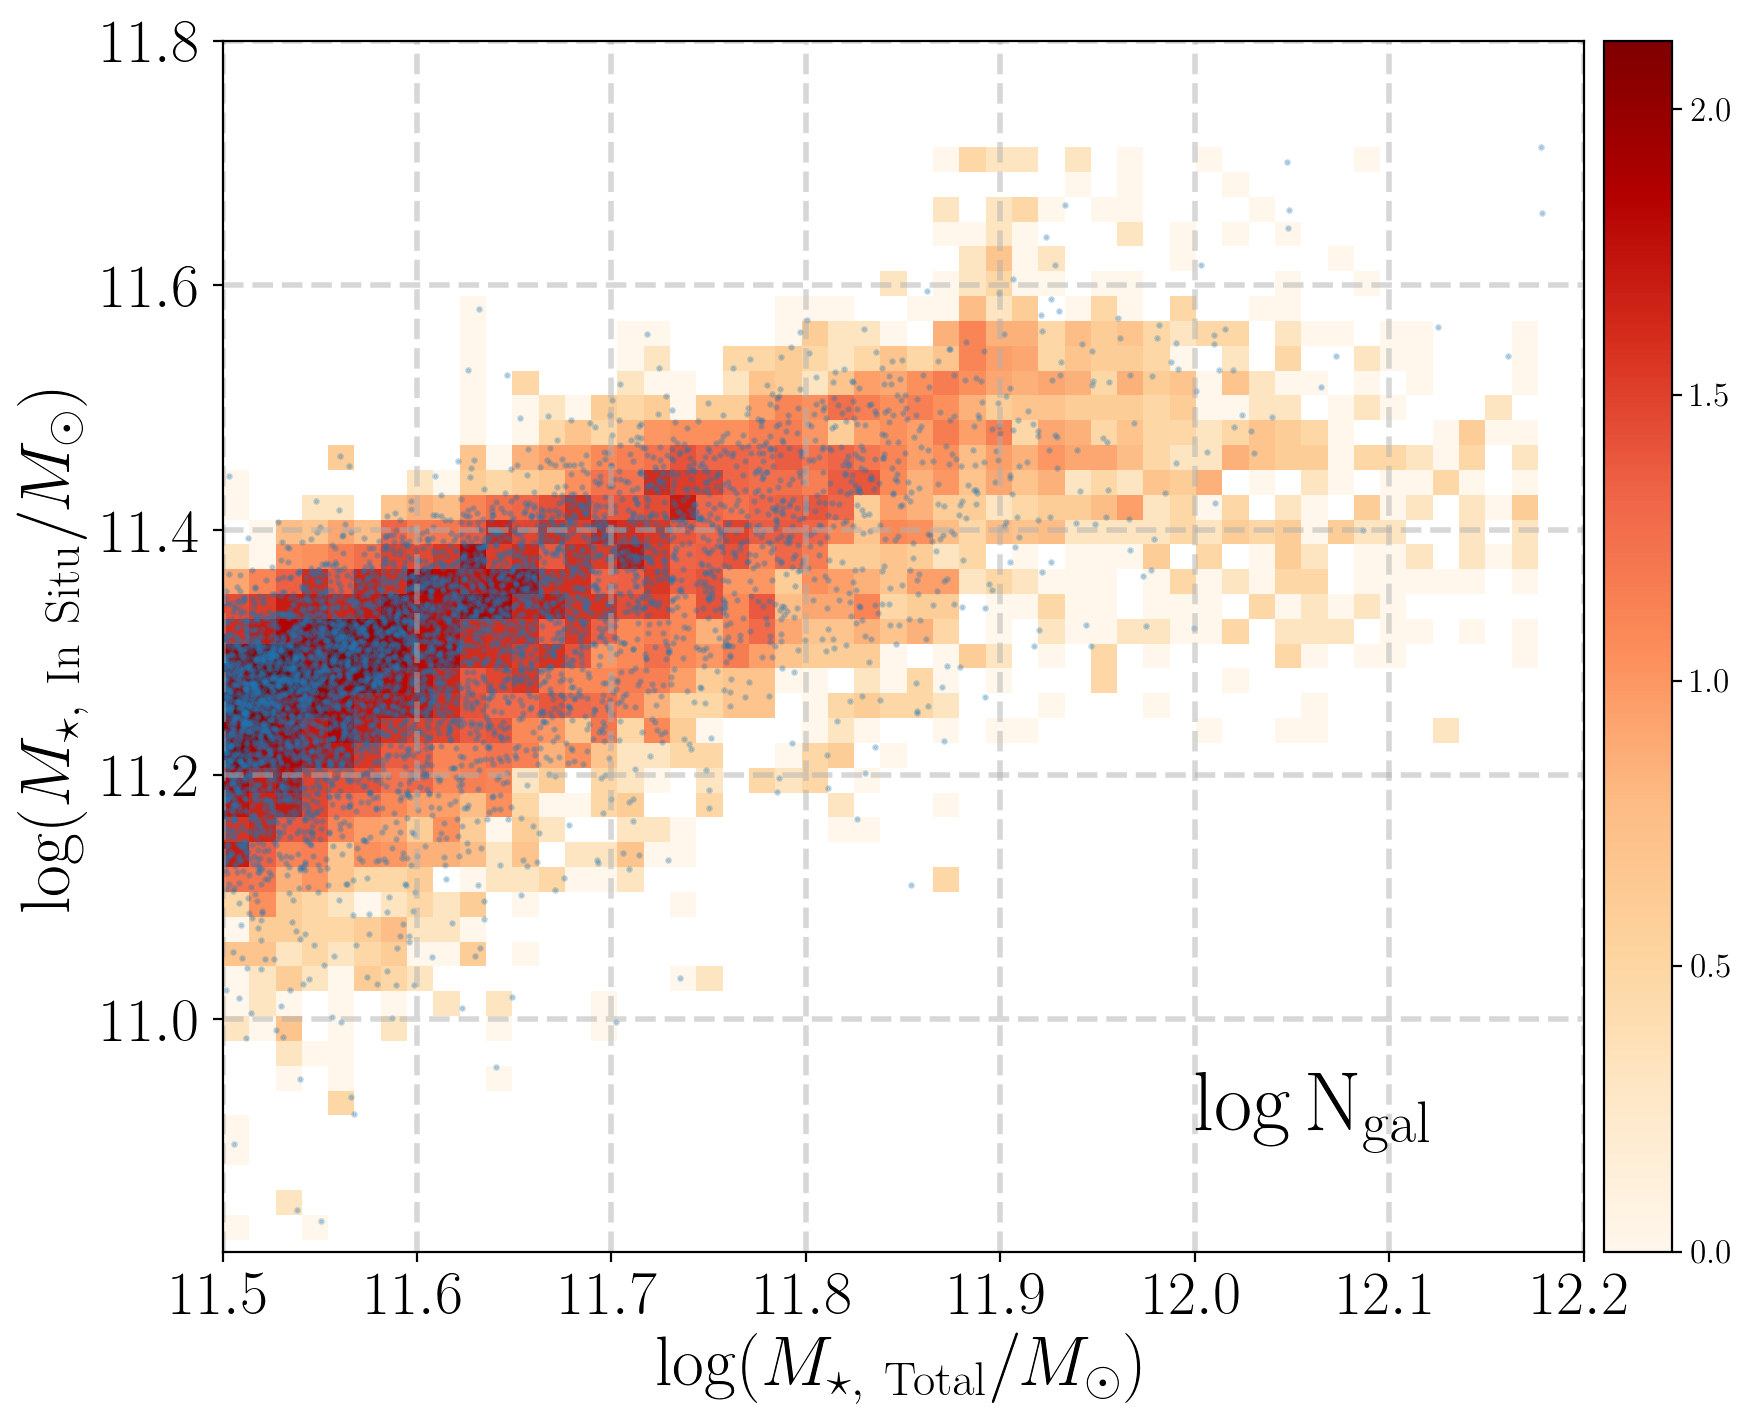

In [146]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10


# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(np.log10(zz_count.T), origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(0, 5)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.scatter(um_test.obs_logms_tot,
            um_test.obs_logms_inn, s=2, alpha=0.25)

ax1.text(12.0, 10.9, r'$\log\mathrm{N_{gal}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

(10.81, 11.800000000000001)

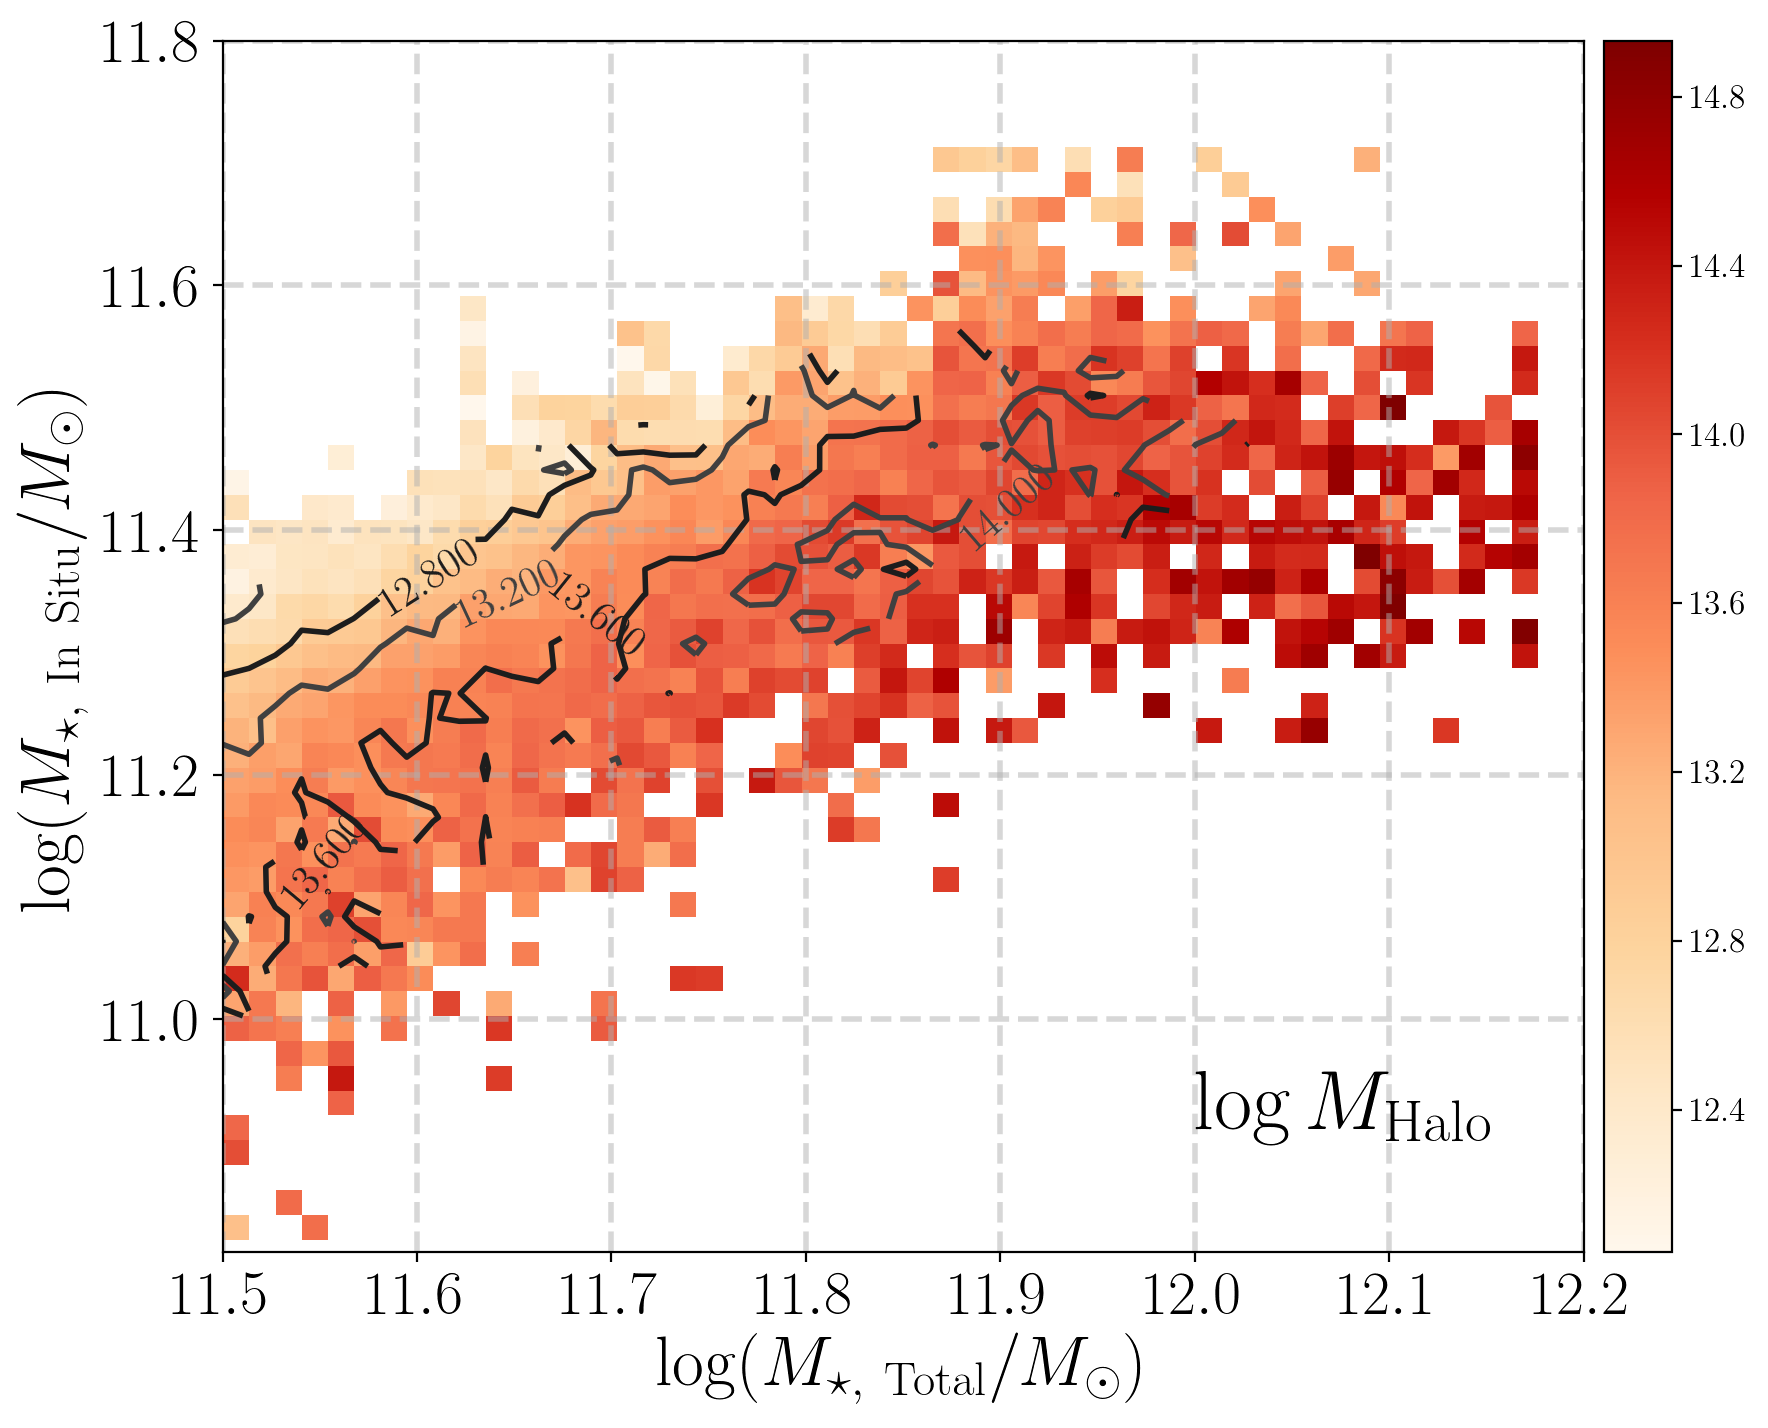

In [148]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_median.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG)

CT = ax1.contour(xedges[:-1], yedges[:-1], gaussian_filter(zz_median.T, 0.2), 
                 6, linewidths=2.0, 
                 colors=[BLK(0.8), BLK(0.9)], 
                 extend='neither')
ax1.clabel(CT, inline=1, fontsize=15)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(zMin, zMax)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.0, 10.9, r'$\log M_{\mathrm{Halo}}$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

(10.81, 11.800000000000001)

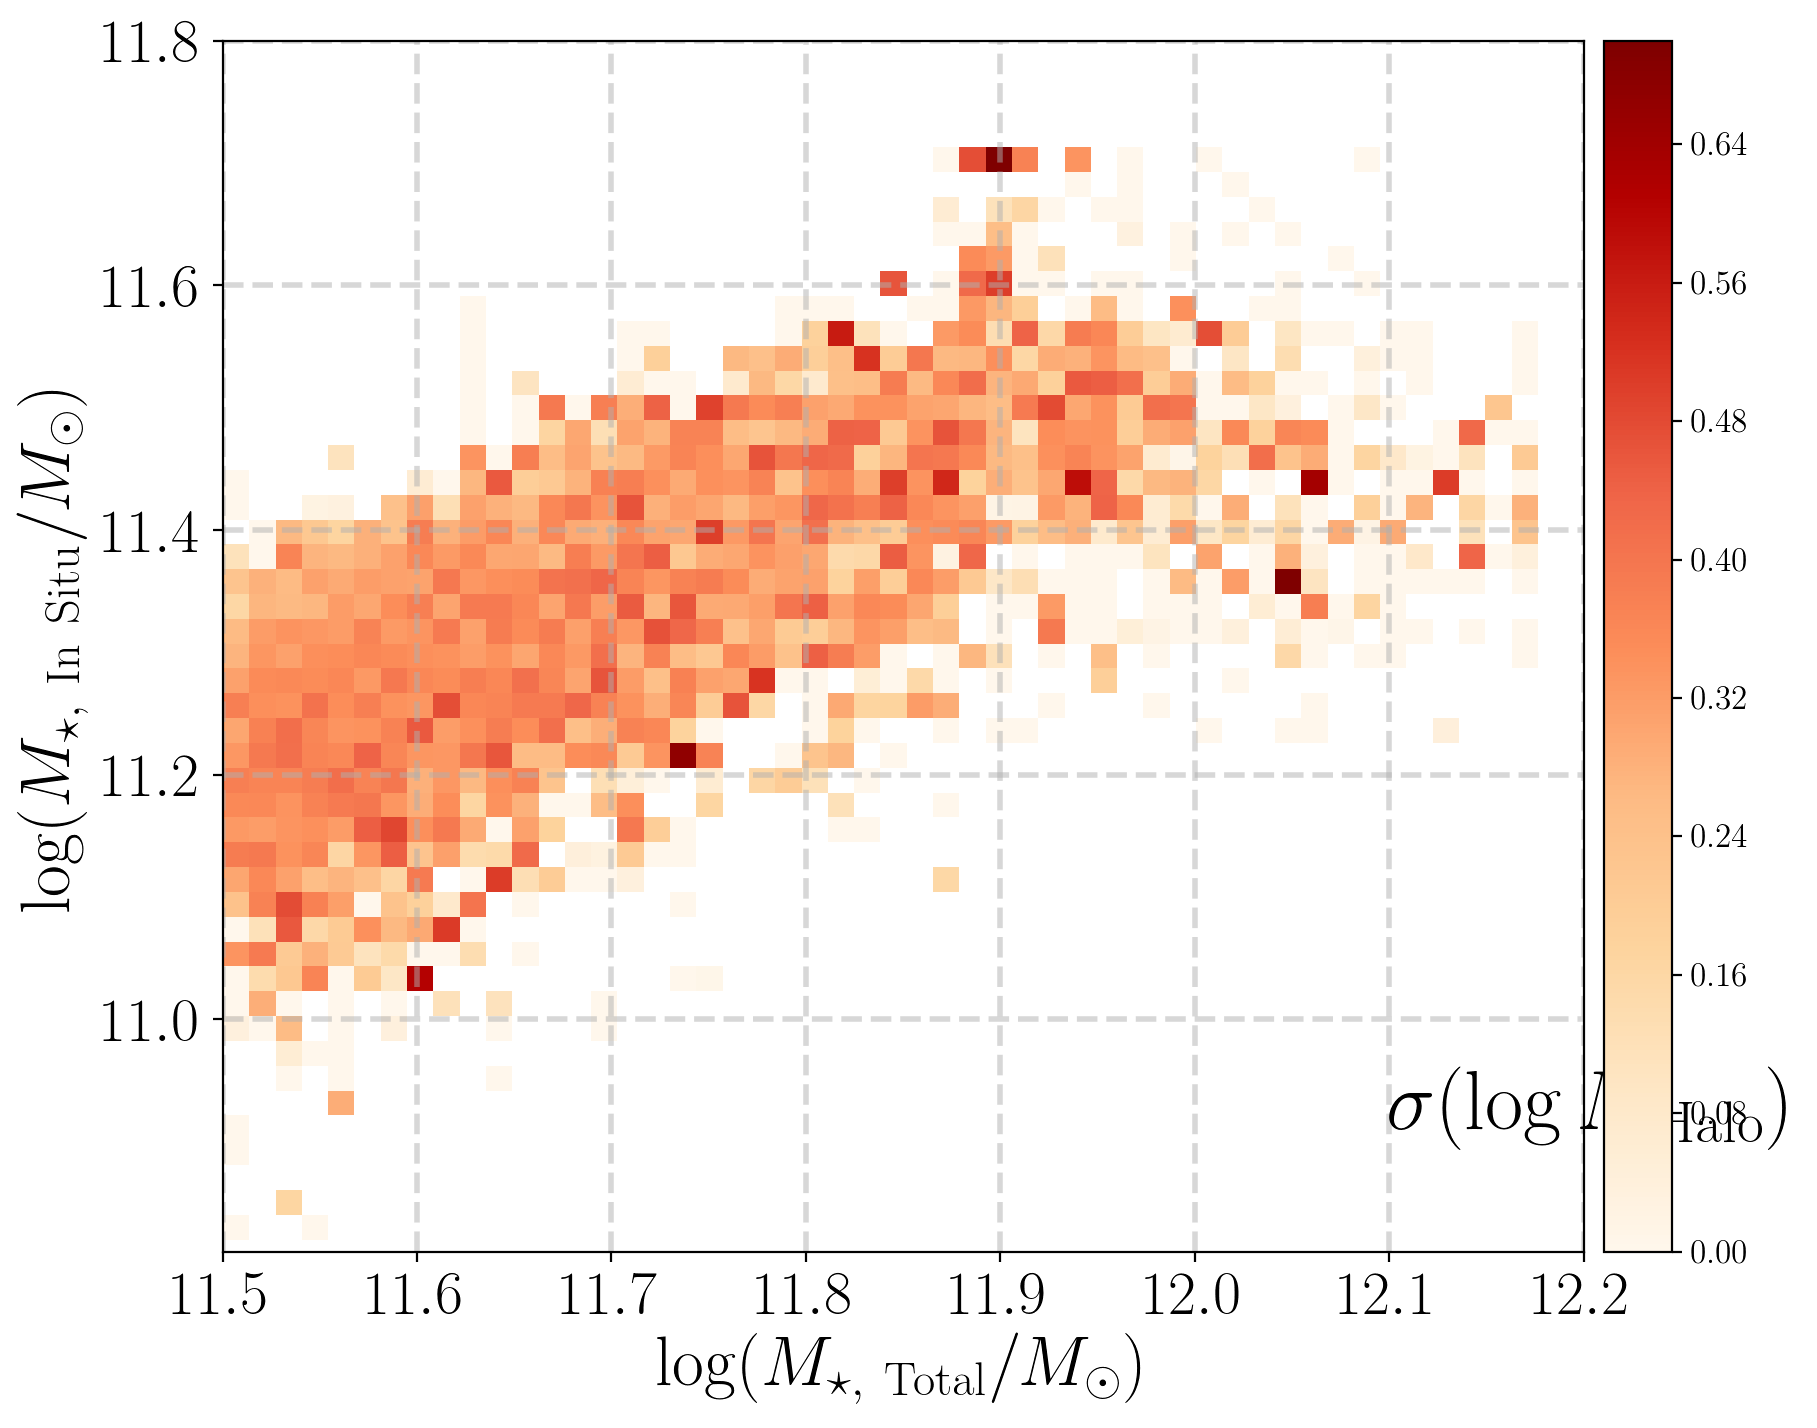

In [149]:
# --------------------------------------------------------------------------------------- #
xtickFormat='$\mathbf{%4.1f}$'
ytickFormat='$\mathbf{%4.1f}$'

ORG = plotting.ORG
BLK = plotting.BLK

nColors = 30
nTicks = 10

# --------------------------------------------------------------------------------------- #
fig = plt.figure(figsize=(9, 7))
fig.subplots_adjust(left=0.19, right=0.995, 
                    bottom=0.13, top=0.995,
                    wspace=0.00, hspace=0.00)
ax1 = fig.add_subplot(111)
ax1.grid(linestyle='--', linewidth=2, alpha=0.5, zorder=0)

HM = ax1.imshow(zz_sigma.T, origin='lower',
                extent=[xedges[0], xedges[-1], 
                        yedges[0], yedges[-1]],
                aspect='auto', interpolation='nearest', 
                cmap=ORG, vmax=0.7)

ax1.set_xlabel('$\log (M_{\star,\ \mathrm{Total}}/M_{\odot})$', size=25)
ax1.set_ylabel('$\log (M_{\star,\ \mathrm{In\ Situ}}/M_{\odot})$', size=25)

for tick in ax1.xaxis.get_major_ticks():
    tick.label.set_fontsize(22)
for tick in ax1.yaxis.get_major_ticks():
    tick.label.set_fontsize(22)
    
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.1)
cTicks = MaxNLocator(nTicks).tick_values(np.nanmin(zz_sigma),
                                         0.7)
cbar = plt.colorbar(HM, cax=cax, ticks=cTicks)
cbar.solids.set_edgecolor("face") 

ax1.text(12.1, 10.9, r'$\sigma(\log M_{\mathrm{Halo}})$', size=30)

# --------------------------------------------------------------------------------------- #
## X, Y limits
ax1.set_xlim(um_test.obs_smf_tot_min, um_test.obs_smf_tot_max)
ax1.set_ylim(10.81, um_test.obs_smf_inn_max)

### Test of `frac1` model 

* Constant fractions for both in-situ and ex-situ components

In [182]:
um_test = InsituExsituModel(model_type='frac1', um_mtot_nbin=90)

frac_ins, frac_exs = 0.8, 0.05
param_simple = (0.76, 1.49, -0.0824, 1.2737, frac_ins, frac_exs)

um_mass_predicted = um_test.umPredictMass(param_simple, 
                                          constant_bin=False)

logms_inn_mod, logms_tot_mod, logms_halo_mod, mask_tot, um_mock_use = um_mass_predicted

# Input stellar mass catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# Input weak lensing profile sample: s16a_wide2_massive_boxbin1
# There are 17 weak lensing profiles in this sample
# Pre-computed SMF for inner logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m10_11.5.fits
# Pre-computed SMF for total logMs: ../data/s16a_massive_wide2/smf/s16a_wide2_massive_smf_m100_11.5.fits
# The volume of the HSC data is    102060083.62 Mpc^3
# Using logm_10 as inner stellar mass.
# Using logm_100 as total stellar mass.
# For inner stellar mass: 
    10 bins at 10.80 < logMinn < 11.80
# For total stellar mass: 
    7 bins at 11.50 < logMtot < 12.20
# The volume of the UniverseMachine mock is    205348196.23 Mpc^3


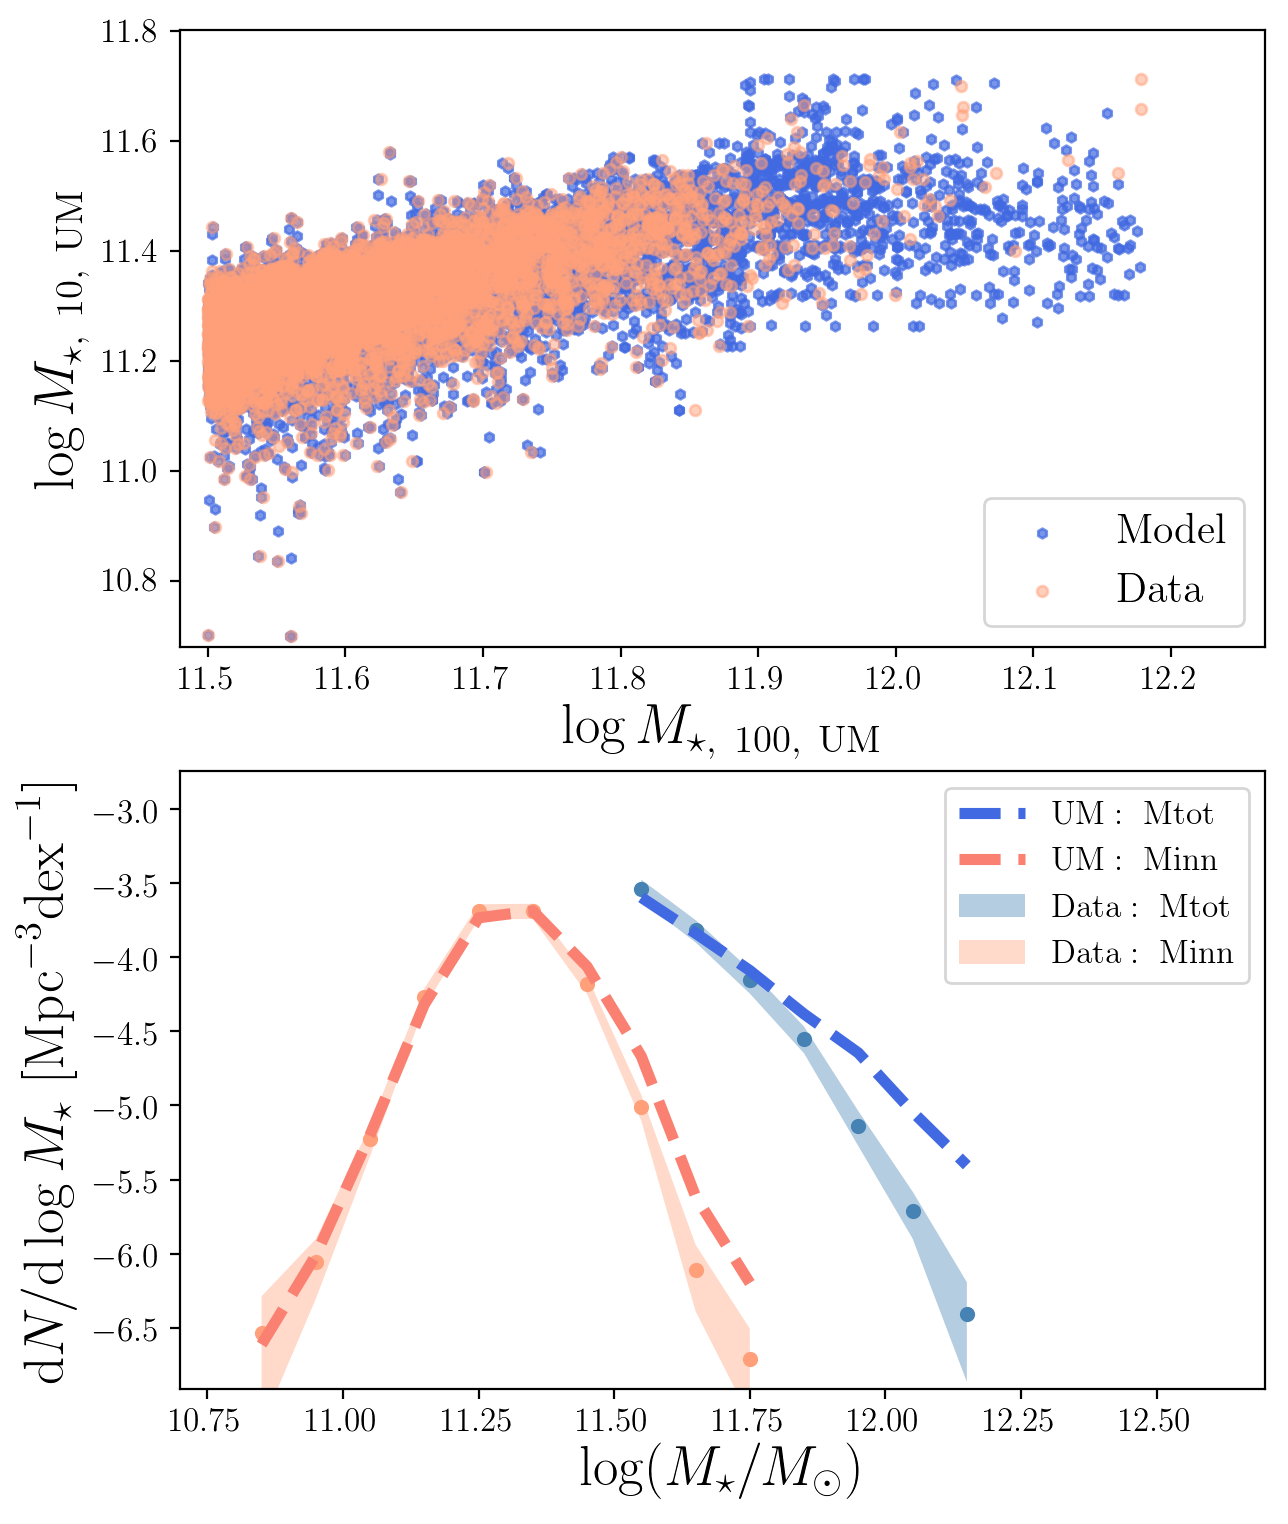

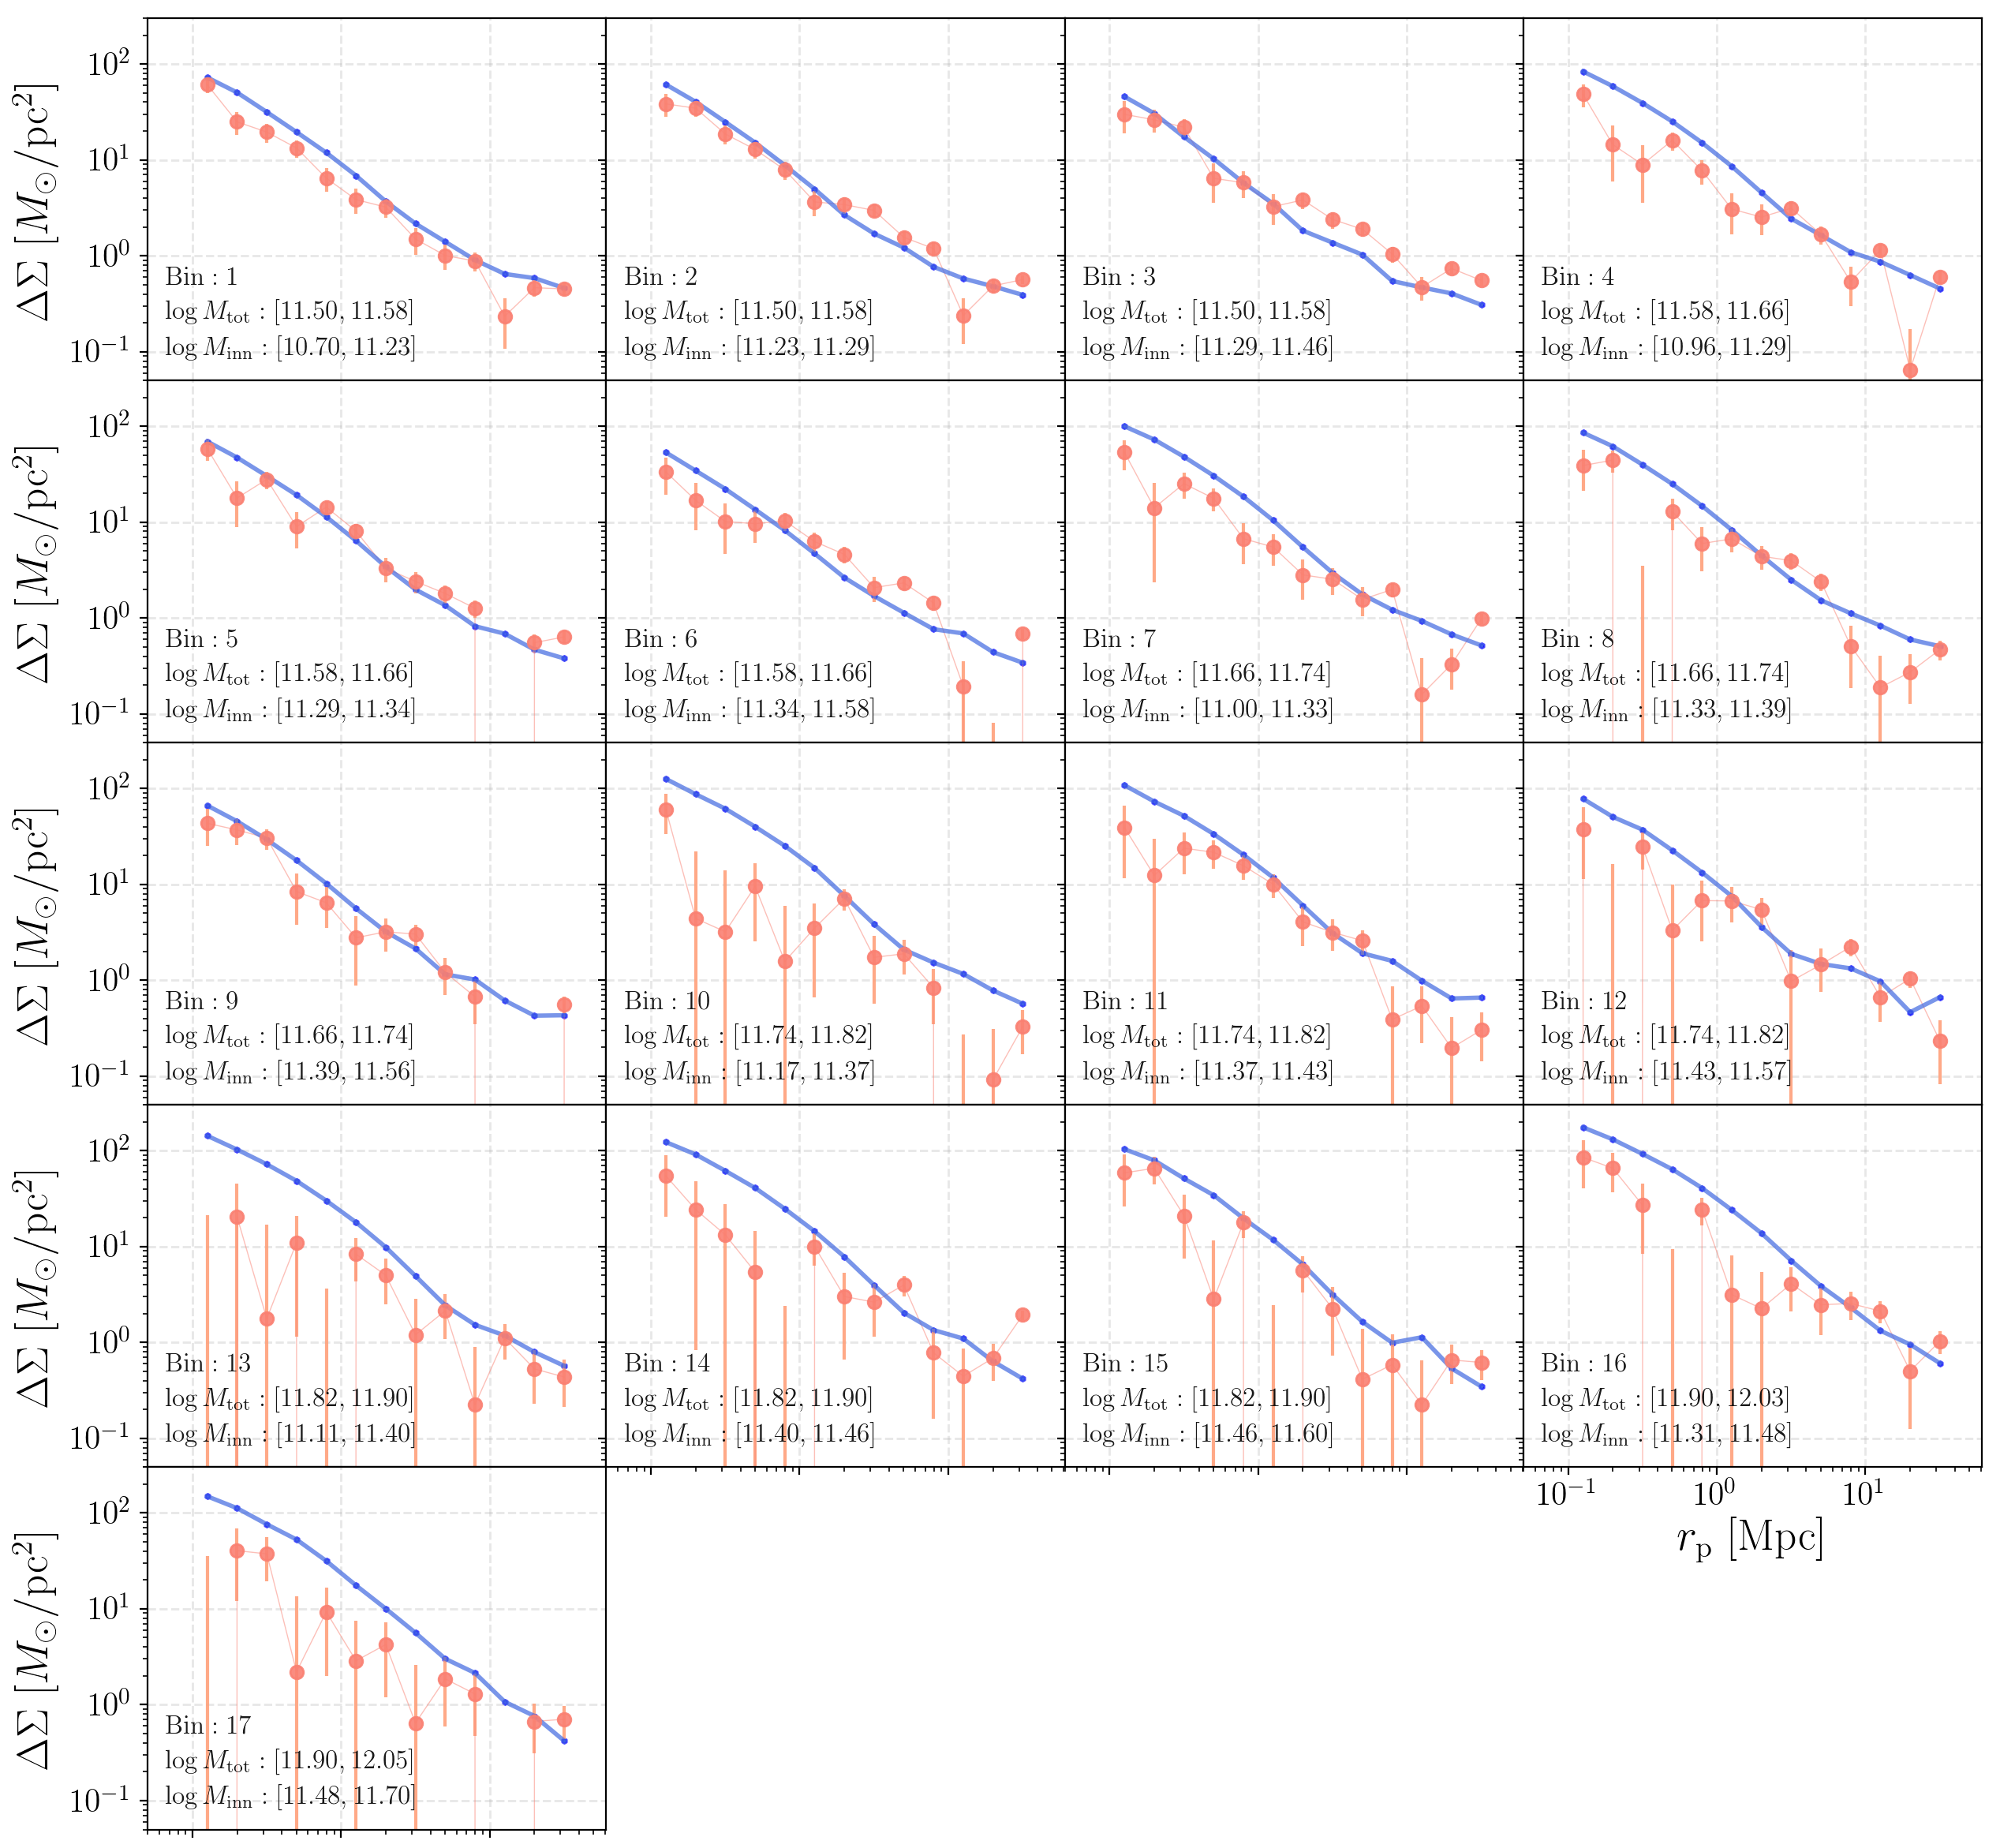

In [188]:
um_mod_predicted = um_test.umPredictModel(param_simple, 
                                          plotSMF=True, 
                                          plotWL=True,
                                          return_wl_mhalo=False,
                                          constant_bin=False)

(um_smf_tot, um_smf_inn, um_wl_profs, 
 logms_inn_mod, logms_tot_mod, logms_halo_mod, 
 mask_tot, um_mock_use) = um_mod_predicted